## IndyCar Dataset Statistics

In [102]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import mxnet as mx
from mxnet import gluon
import pickle
import json
import random
import inspect
from scipy import stats
from sklearn.metrics import mean_squared_error
from pathlib import Path
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#import plotly.graph_objects as go

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_stagedata(startbase = 11, predlen=2, contextlen=40):
    """
    start from lap 11(offset=10), sync to testset in ranknet evaluation
    
    input: acldata, rankdata, the whole dataset
    output: stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank']
    """
    carlist = set(acldata['car_number'])
    data = []
    for curcarno in carlist:
        car = acldata[acldata['car_number']==curcarno]
        #print(car['time_diff'].describe())

        cols=['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']
        colid={key:idx for idx, key in enumerate(cols)}

        cardata = rankdata[rankdata['car_number'] == curcarno]

        carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
            ['completed_laps','rank','car_number','lap_status','track_status',
            'pit_stop_count','current_status','start_position']].values]
        
        totallaps = len(carstatus)
        
        pit_lap = 0
        pit_in_caution = 0
        #only need startlap, startrank, endrank
        for row in carstatus:
            curlap = int(row[colid['completed_laps']])
            
            #if (curlap >= startbase) and (curlap + predlen < totallaps):
            if (curlap >= 0) and (curlap + predlen < totallaps):
                #to reserve the startposition
            
                #valid record here
                
                #hex2int
                #if start_lap == 0:
                #    start_rank = int(row[colid['start_position']], 16)     
                #else:
                #    start_rank = carstatus[start_lap][colid['rank']]
                
                #start_lap = curlap - contextlen
                #if start_lap < 1:
                #    start_lap = 1
                
                start_rank = carstatus[curlap][colid['rank']]
            
                end_lap = curlap + predlen
                end_rank = carstatus[end_lap][colid['rank']]
                
                stage = curlap - startbase
                #add one record
                #stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank']
                data.append([curcarno,stage,curlap, end_lap, pit_lap, pit_in_caution, start_rank, end_rank])
            
    data = np.array(data)
    #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
    df = pd.DataFrame({'car_number': data[:, 0], 'stage': data[:, 1],'start_lap': data[:, 2],
                      'end_lap': data[:, 3], 'pit_lap': data[:, 4], 'pit_in_caution': data[:, 5],
                       'start_rank': data[:, 6],'end_rank': data[:, 7]})
    return df, data

In [47]:
_inlap_status = 0
_featureCnt = 9
#
# input data parameters
#
# event -> car#, maxlapa
_race_info = {}
# the races have 7 years data 
races = ['Indy500', 'Texas','Iowa','Pocono']
years = ['2013','2014','2015','2016','2017','2018','2019']

events = []
for race in races:
    events.extend([f'{race}-{x}' for x in years])

events.extend(['Phoenix-2018','Gateway-2018','Gateway-2019'])
events_id={key:idx for idx, key in enumerate(events)}

# dataset shared
dataOutputRoot = "data/"
covergap = 1
dbid = f'IndyCar_d{len(events)}_v{_featureCnt}_p{_inlap_status}'
LAPTIME_DATASET = f'{dataOutputRoot}/laptime_rank_timediff_pit-oracle-{dbid}.pickle' 
STAGE_DATASET = f'{dataOutputRoot}/stagedata-{dbid}.pickle' 
PITCOVERED_DATASET = f'{dataOutputRoot}/pitcoveredlaps-{dbid}-g{covergap}.pickle'
PITSTOP_DATASET = f'{dataOutputRoot}/pitstop-{dbid}.csv' 
    
print('Load laptime and stage dataset:',LAPTIME_DATASET, STAGE_DATASET)
with open(LAPTIME_DATASET, 'rb') as f:
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 
with open(STAGE_DATASET, 'rb') as f:
    #stagedata = pickle.load(f, encoding='latin1') 
    stagedata_raw, _race_info, _events, _events_id = pickle.load(f, encoding='latin1') 
with open(PITCOVERED_DATASET, 'rb') as f:
     pitdata = pickle.load(f, encoding='latin1')
pitstop_df = pd.read_csv(PITSTOP_DATASET)

#check it
if not _events == events:
    print('Error, events mismatch at:', STAGE_DATASET)
    sys.exit(-1)

#trainrace = 'Indy500','Iowa','Pocono','Texas'
trainrace = 'Texas'
    
#_train_events = [events_id[x] for x in [f'{trainrace}-{x}' for x in ['2013','2014','2015','2016','2017']]]
#_test_events = [f'{trainrace}-{x}' for x in ['2018','2019']]
if trainrace == 'Pocono':
    # 2014, 2019 is bad
    _train_years = ['2013','2015','2016','2017']
    testevents = [f'{trainrace}-2018']
else:
    _train_years = ['2013','2014','2015','2016','2017']
    testevents = [f'{trainrace}-2018',f'{trainrace}-2019']
    
    
stintlen_config = {
    # sel_stintlen, sel_stintlen_caution, binsize, 
    'Indy500':(23,15, 50),
    'Pocono':(23,15,50),
    'Texas':(30,15, 70 ),
    'Iowa':(40,15, 100),
    'Phoenix':(23,15, 50),
    'Gateway':(23,15, 50)
}

_train_events = [events_id[x] for x in [f'{trainrace}-{x}' for x in _train_years]]

#load data
_trim = 0
_include_final = True
_include_stintlen = True
#_include_stintlen = False
include_str = '1' if _include_final else '0'
stint_str = '1' if _include_stintlen else ''


_context_len = 60

Load laptime and stage dataset: data//laptime_rank_timediff_pit-oracle-IndyCar_d31_v9_p0.pickle data//stagedata-IndyCar_d31_v9_p0.pickle


In [92]:
cols = ['event', 'totalcars', 'totallaps', 'pitlaps', 'pitcovered', 
        'totalpits', 'caution', 'normal', 'longnormal', 
        'longpitsratio', 'pitlapratio', 'longpitslapratio',
        'ranknochange_p1','ranknochange_p2'] 

In [93]:
plen = 2
dataroot='data/'
output_file = f'{dataroot}/shortterm-IndyCar-d{len(events)}-end{include_str}{stint_str}-t{plen}-c{_context_len}.csv'
stagedf = pd.read_csv(output_file )

In [94]:
plen = 1
stagedata = {}
rec = []
for event in events:
    tid = events_id[event]    
    
    alldata, rankdata, acldata, flagdata = stagedata_raw[event]
    carlist = set(acldata['car_number'])
    laplist = set(acldata['completed_laps'])
    print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)-1))

    #cat#
    totalcars = len(carlist)
    
    #p1
    stage, data = get_stagedata(contextlen = _context_len, predlen=1)

    df = stage
    startrank = df.start_rank.values
    endrank = df.end_rank.values
    p1_ratio = np.sum(startrank == endrank)/len(startrank)
    print('event:', event, 'id:', tid, 'len:', len(df),'ratio:', 
         np.sum(startrank == endrank)/len(startrank))    
    
    #p2
    indycar = stagedf[stagedf['eventid']==tid]
    targets = indycar.target.values
    p2_ratio = np.sum(targets==0)/len(targets)
    print('event:', event, 'id:', tid, 'len:', len(targets),'ratio:', np.sum(targets==0)/len(targets))    
    
    #pit
    totallaps = np.max(rankdata.completed_laps.to_numpy())
    pitlaps, pitcoveredlaps = pitdata[event]
    
    #normal, caution
    #dfall = pitstop_df[pitstop_df['raceid']==trainrace]
    dfall = pitstop_df[pitstop_df['eventid']==tid]
    lapcnt = dfall[dfall['pit_oncaution']==0].lap_cnt
    print('normal laps lapcnt min:', np.min(lapcnt), 'max:', np.max(lapcnt))
    lap_cnt = dfall[dfall['pit_oncaution']==1].lap_cnt
    print('Caution laps lapcnt min:', np.min(lapcnt), 'max:', np.max(lapcnt))
    
    cautionpits = dfall[dfall['pit_oncaution']==1]
    normalpits = dfall[dfall['pit_oncaution']==0]
    raceid = event.split('-')[0]
    longnormalpits = dfall[(dfall['pit_oncaution']==0) & (dfall['lap_cnt'] >= stintlen_config[raceid][0])]
    
    pitsdf = rankdata[rankdata['lap_status']=='P']
    #cautionpits = pitsdf[pitsdf['track_status']!='G']
    #normalpits = pitsdf[pitsdf['track_status']=='G']
    #stint_data = normalpits[['completed_laps', 'last_pitted_lap']].values
    #stint_len = stint_data[:,0] - np.array([int(x, 16) for x in stint_data[:, 1]])
    #normalpits['stint_len'] = stint_len
    #longnormalpits = normalpits[normalpits['stint_len'] >= stintlen_config[raceid][0]]
    
    longpitsratio = len(longnormalpits) / len(pitsdf)
    
    #get covered laps
    longpitslaps = set(list(longnormalpits.lap_number.values))
    
    
    
    rec.append([event, totalcars, totallaps, len(pitlaps), len(pitcoveredlaps), 
                len(pitsdf), len(cautionpits), len(normalpits),len(longnormalpits),
                longpitsratio, len(pitlaps)/ totallaps, len(longpitslaps) / totallaps, 
                p1_ratio, p2_ratio])

Indy500-2013: carno=33, lapnum=200
event: Indy500-2013 id: 0 len: 5863 ratio: 0.6657001535050315
event: Indy500-2013 id: 0 len: 5476 ratio: 0.5049306062819576
normal laps lapcnt min: 3 max: 33
Caution laps lapcnt min: 3 max: 33
Indy500-2014: carno=33, lapnum=200
event: Indy500-2014 id: 1 len: 6107 ratio: 0.7543802194203373
event: Indy500-2014 id: 1 len: 5711 ratio: 0.6293118543162318
normal laps lapcnt min: 0 max: 33
Caution laps lapcnt min: 0 max: 33
Indy500-2015: carno=33, lapnum=200
event: Indy500-2015 id: 2 len: 5591 ratio: 0.7721337864424969
event: Indy500-2015 id: 2 len: 5219 ratio: 0.6547231270358306
normal laps lapcnt min: 0 max: 40
Caution laps lapcnt min: 0 max: 40
Indy500-2016: carno=33, lapnum=200
event: Indy500-2016 id: 3 len: 5863 ratio: 0.6732048439365512
event: Indy500-2016 id: 3 len: 5467 ratio: 0.5075910005487471
normal laps lapcnt min: 2 max: 38
Caution laps lapcnt min: 2 max: 38
Indy500-2017: carno=33, lapnum=200
event: Indy500-2017 id: 4 len: 5617 ratio: 0.72618835

In [95]:
retdf = pd.DataFrame(data=rec, columns=cols)

In [98]:
pd.options.display.float_format = '{:,.2f}'.format
retdf[['event', 'pitlaps', 'pitcovered', 
        'totalpits', 'caution', 'normal', 'longnormal', 
        'longpitsratio', 'pitlapratio', 'longpitslapratio',
        'ranknochange_p1','ranknochange_p2'] ]

,event,pitlaps,pitcovered,totalpits,caution,normal,longnormal,longpitsratio,pitlapratio,longpitslapratio,ranknochange_p1,ranknochange_p2
0,Indy500-2013,70,119,198,48,150,137,0.69,0.35,0.23,0.67,0.50
1,Indy500-2014,75,126,228,83,145,130,0.57,0.38,0.20,0.75,0.63
2,Indy500-2015,48,80,198,108,90,88,0.44,0.24,0.10,0.77,0.65
3,Indy500-2016,70,120,259,189,70,61,0.24,0.35,0.14,0.67,0.51
4,Indy500-2017,70,124,248,173,75,62,0.25,0.35,0.08,0.73,0.58
5,Indy500-2018,76,122,192,77,115,107,0.56,0.38,0.24,0.71,0.57
6,Indy500-2019,74,102,217,85,132,123,0.57,0.37,0.24,0.74,0.64
7,Texas-2013,55,112,94,27,67,59,0.63,0.24,0.18,0.82,0.71
8,Texas-2014,58,105,122,40,82,77,0.63,0.23,0.17,0.81,0.72
9,Texas-2015,75,136,123,23,100,78,0.63,0.30,0.22,0.84,0.76


In [99]:
retdf.to_csv(f'{dataroot}/indycar_data_statistics.csv')

## pca draw

In [110]:
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [154]:
def dim_reduction(data, title, ranknet_model_name,dim_model_name='PCA', show_lap_info=False):
    if dim_model_name == 'PCA':
        dim_model = decomposition.PCA(n_components=2)
        X=dim_model.fit_transform(data)
    elif dim_model_name == 'TSN':
        dim_model = TSNE(n_components=2)
        X=dim_model.fit_transform(data)
    else:
        X = data
    
    fig = go.Figure()
    
    if show_lap_info:
        distances = []
        laps = []
        lap_distance_info = []
        for i in range(X.shape[0]):
            lap = 200 - i
            distance = np.abs(find_nearest(pitstops[0], lap) - lap)
            laps.append(lap)
            distances.append(distance)
            lap_distance_info.append("(%.2f, %.2f)<br>lap:%d<br>distance:%d" %(X[i,0], X[i,1],lap, distance))
        
        distances = np.array(distances)
        laps = np.array(laps)
        
        pit_close_indices = np.where(distances < 3)[0]
        pit_far_indices = np.where(distances >= 3)[0]
        
        #print(lap_distance_info[[1,2,3]])
        
        #ax.scatter(X[distances >= 3,0], X[distances >= 3,1],s=100, c=distances[distances >= 3], cmap='Greys')
        fig.add_trace(go.Scatter(x=X[pit_far_indices,0],
                                y=X[pit_far_indices,1],
                                mode='markers',
                                name= 'not close',
                                marker=dict(color=distances[pit_far_indices], colorscale='Plotly3_r',line_width=1),
                                #marker_color=distances[distances >= 3],
                                ##text=laps[distances >= 3]
                                hovertext=[i for i in lap_distance_info if lap_distance_info.index(i) in pit_far_indices],
                                hoverinfo='text'
                                
                                )) # hover text goes here
        fig.add_trace(go.Scatter(x=X[pit_close_indices,0],
                                y=X[pit_close_indices,1],
                                name='pitstop_close',
                                mode='markers',
                                marker=dict(color=distances[distances < 3], colorscale='Aggrnyl_r',line_width=1),
                                #marker_color=distances[distances >= 3],
                                hovertext=[i for i in lap_distance_info if lap_distance_info.index(i) in pit_close_indices],
                                hoverinfo='text'
                                ))
        
    else:
        print('else')
        fig.add_trace(go.Scatter(x=X[:,0],
                                 y=X[:,1],
                                 mode='markers',
                                 #marker=dict(color=[200 - i for i in range(X.shape[0])], colorscale='Viridis', showscale=True),
                                 #hovertext=["(%.2f, %.2f)<br>lap:%d" %(X[i,0], X[i,1],200-i)for i in range(X.shape[0])],
                                 #marker = dict(color= marker_color, colorscale='Viridis', showscale=True),
                                 marker = dict(color = marker_color, size=12),
                                 text = hovertext,
                                 hovertext = hovertext,
                                 hoverinfo='text'
                                ))
        
    
    fig.update_layout(title= ranknet_model_name + ': ' + title, font=dict(size=18))
    fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'xaxis': {
            'linecolor': 'black',
            'linewidth': 0.5,
            'mirror': True,
            'showgrid': False
        },
        'yaxis': {
            'linecolor': 'black',
            'linewidth': 0.5,
            'mirror': True,

            'showgrid': False
        }
    })
    fig.show()
    return fig


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [172]:
#f1=dim_reduction(theta, 'PCA Theta', ranknet_model_name='RankNet-oracle',dim_model_name='PCA')
#f3=dim_reduction(theta, 'tSNE Theta', ranknet_model_name='RankNet-oracle', dim_model_name='tsne')
raceinfo = retdf.event.values
raceid = [x.split('-')[0] for x in raceinfo]
#colors = {x:events_id[x+'-2018']*4 for x in raceid}
colors = {
    'Indy500':'#ff0000',
    'Pocono':'#00ff00',
    'Texas':'#0000ff',
    'Iowa':'#f5d12b',
    'Phoenix':'#000000',
    'Gateway':'#800080',
    }

retdf = pd.read_csv(f'{dataroot}/indycar_data_statistics.csv')


In [190]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

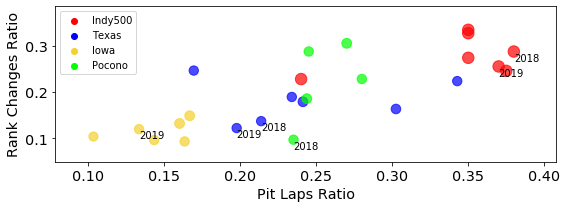

In [206]:
  
races = ['Indy500', 'Texas']
years = ['2013','2014','2015','2016','2017','2018','2019']
selevents = []
for race in races:
    selevents.extend([f'{race}-{x}' for x in years])
selevents.extend([f'Iowa-{x}' for x in ['2013','2015','2016','2017','2018','2019']])
selevents.extend([f'Pocono-{x}' for x in ['2013','2015','2016','2017','2018']])
    

data = retdf[retdf['event'].isin(selevents)].to_numpy()
marker_color = [ colors[x.split('-')[0]] for x in selevents ]
area = retdf[retdf['event'].isin(selevents)]['totalcars'].values * 4
hovertext = selevents

x = data[:, -4]    
y = 1 - data[:, -2]
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
plt.scatter(x, y, s=area, c=marker_color, alpha=0.7)
ax.set_xlabel('Pit Laps Ratio')
ax.set_ylabel('Rank Changes Ratio')

for i, txt in enumerate(selevents):
    if (txt.find('2018')>0 and txt.find('Iowa') < 0) or txt.find('2019')>0:
        ax.annotate(txt.split('-')[1], (x[i], y[i]-0.02))

xlim = ax.get_xlim()
ylim = ax.get_ylim()

#legend        
for race in ['Indy500', 'Texas','Iowa','Pocono']:
    ax.scatter([-1],[-1], label=race, c=colors[race])
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.legend(prop={'size': 10})         
        
plt.tight_layout()
plt.savefig(f'figs/indycar_statistics.pdf')

In [173]:
len(retdf)

31

In [179]:
marker_color = [ colors[raceid[idx]] for idx, x in enumerate(raceinfo) ]
hovertext = raceinfo

data = retdf[['longpitsratio', 'pitlapratio', 'longpitslapratio',
        'ranknochange_p1','ranknochange_p2']].values

f1=dim_reduction(data, 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='PCA')

else


In [145]:
data = retdf.to_numpy()
f1=dim_reduction(data[:, [-5,-4,-2]], 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='PCA')

else


In [149]:
f1=dim_reduction(data[:, [-4,-1]], 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='PCA')

else


In [150]:
data[:, [-4,-1]]

array([[0.35, 0.5049306062819576],
       [0.375, 0.6293118543162318],
       [0.24, 0.6547231270358306],
       [0.35, 0.5075910005487471],
       [0.35, 0.5841792760007661],
       [0.38, 0.5692883895131086],
       [0.37, 0.6365251376798721],
       [0.2412280701754386, 0.7103274559193955],
       [0.23387096774193547, 0.7240545294635005],
       [0.3024193548387097, 0.7591345172484181],
       [0.34274193548387094, 0.6769533814839134],
       [0.1693548387096774, 0.6357598978288633],
       [0.21370967741935484, 0.7754142409314823],
       [0.1975806451612903, 0.809970174691095],
       [0.16, 0.7920974889217134],
       [0.16333333333333333, 0.8539325842696629],
       [0.16666666666666666, 0.773609958506224],
       [0.14333333333333334, 0.8551950293406972],
       [0.10333333333333333, 0.8314811441063946],
       [0.16333333333333333, 0.8539325842696629],
       [0.13333333333333333, 0.820281124497992],
       [0.24375, 0.7310841794955781],
       [0.235, 0.8692196531791907],
  

In [152]:
f1=dim_reduction(data[:, [-3,-1]], 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='PCA')

else


In [153]:
data[:, [-3,-1]]

array([[0.23, 0.5049306062819576],
       [0.205, 0.6293118543162318],
       [0.105, 0.6547231270358306],
       [0.135, 0.5075910005487471],
       [0.08, 0.5841792760007661],
       [0.245, 0.5692883895131086],
       [0.245, 0.6365251376798721],
       [0.17543859649122806, 0.7103274559193955],
       [0.1693548387096774, 0.7240545294635005],
       [0.2217741935483871, 0.7591345172484181],
       [0.1693548387096774, 0.6769533814839134],
       [0.004032258064516129, 0.6357598978288633],
       [0.11290322580645161, 0.7754142409314823],
       [0.13306451612903225, 0.809970174691095],
       [0.1, 0.7920974889217134],
       [0.09333333333333334, 0.8539325842696629],
       [0.08, 0.773609958506224],
       [0.07, 0.8551950293406972],
       [0.05333333333333334, 0.8314811441063946],
       [0.09333333333333334, 0.8539325842696629],
       [0.07, 0.820281124497992],
       [0.1625, 0.7310841794955781],
       [0.2, 0.8692196531791907],
       [0.055, 0.544841158279449],
       [0.

In [155]:
f1=dim_reduction(data[:, [-3,-1]], 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='no')

else


In [156]:
f1=dim_reduction(data[:, [-4,-1]], 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='no')

else


In [158]:
f1=dim_reduction(data[:, [-5,-2]], 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='no')

else


In [159]:
f1=dim_reduction(data[:, [-4,-2]], 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='no')

else


In [160]:
f1=dim_reduction(data[:, [-3,-2]], 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='no')

else


In [161]:
f1=dim_reduction(data[:, [-3,-2]], 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='PCA')

else


In [184]:
#data = retdf.to_numpy()
d = data[:, [-4,-2]]
d[:, 1] = 1 - d[:, 1]
f1=dim_reduction(d, 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='PCA')

else


In [185]:
f1=dim_reduction(d, 'IndycarDataset', ranknet_model_name='indycar',dim_model_name='no')

else
